# Project 2 report

# Division

| Name | Contributions|
| --- | --- |
| Jin Mou | draw the data map in part 2, combine all the codes and write the report |
| Kaiqian Ji | draw diagrams based on monthly data |
| Yixing Wang | draw diagrams based on daily data, do weather condition and air condition analysis, and draw heatmap in Extensions |
| All members | take part in group discussion, help each other improve codes and solve problems |

# Introduction:
In this report, we select London as our target to investigate its air condition among locations.
- Firstly, we draw a data map, you get easily to get the latest informtion of each air polluants among each locations in London from the map.
- Secondly, we draw a diagram to illustrate how air polluants change recently based on daily data.
- Moreover, we explore how air polluants change from January to October in 2021, here we adjust daily data to monthly data by taking average.
- Finally, we supplement a heatmap for you to view data from another way.

Our whole report is aimed at helping you build a visual impression of air conditions in London.

# 1. Import relevant packages

In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import meteostat 
import openaq
import folium
import folium.plugins
import branca.colormap as cm
import ipywidgets
import warnings
from datetime import datetime
from scipy.stats import kstest
from scipy import stats
import webbrowser

## relevant links abount packages
# ipywidget: https://ipywidgets.readthedocs.io/en/latest/
# folium: http://python-visualization.github.io/folium/
# branca.colormap: https://python-visualization.github.io/branca/colormap.html

# 2. Data map

* In this part, we display the overview of the latetst air polluants conditions among stations in London via a data map. 

* The latest each polluant measurement of each location is marked on the map. On the map, we display pm10, pm2.5, o3', co, no2 and so2, since only these kind of data are available.

## 2.1 Define map function
* Build "air_polluant_map" function to visualise the levels of a specific air pollution among locations in London on the map 

In [4]:
def air_polluant_map(polluant):
    """
    Draw the air polluant map for input polluant in London
    >>> input: one specific polluant in the following list:
        ['pm10', 'pm25', 'o3', 'co', 'no2', 'so2']
    >>> output: a map for London
    """
    ## (1). retrieve data
    # build api
    api = openaq.OpenAQ(version='v2')
    # get the city information about location
    city_loc = api.locations(city="London", df=True)
    # get the latest polluant measurements in city_polluant
    city_parameters = api.latest(city='London', has_geo=True, limit=10000, df=True)
    city_polluant = city_parameters.loc[city_parameters.loc[:, "parameter"] == polluant, :]
    # convert row index to the first column
    city_polluant = city_polluant.reset_index()
    
    ## (2). buid relevant dataframe
    # buid the dataframe including relevant information from city_loc and city_polluant
    merge1 = city_loc.loc[:, ["name", "coordinates.latitude", "coordinates.longitude"]]
    # change the column names of merge1 to match merge2
    merge1 = merge1.rename({'name': 'location'}, axis=1)
    # if we can get the location details of some places, then just ignore them
    merge1 = merge1[merge1["coordinates.latitude"].notna()]
    merge1 = merge1[merge1["coordinates.longitude"].notna()]
    merge2 = city_polluant.loc[:, ["location", "lastUpdated", "parameter", "value"]]
    data = pd.merge(merge1, merge2, how="left", on="location")
    
    ## (3). categorize polluant levels
    # categorize the polluant into 4 levels evenly in terms of measurement values
    # get the maximal and minimal values of the polluant measurement, then do some simple computations
    polluant_5 = merge2["value"].max() 
    polluant_1 = merge2["value"].min()
    polluant_2 = polluant_1 + (polluant_5 - polluant_1) / 4
    polluant_3 = polluant_2 + (polluant_5 - polluant_1) / 4
    polluant_4 = polluant_3 + (polluant_5 - polluant_1) / 4
    # special circumstance: maximal measurement = minimal measurements
    if polluant_1 == polluant_5:
        polluant_5 = polluant_1 * 1.2
        polluant_4 = polluant_1 * 1.1
        polluant_3 = polluant_1 * 1.0
        polluant_2 = polluant_1 * 0.9
        polluant_1 = polluant_1 * 0.8
    # get the polluant_level list   
    polluant_level = [polluant_1,polluant_2,polluant_3,polluant_4, polluant_5]
    
    ## (4) build colormap as map legends using branca.colormap(cm) package
    color_list = ["#002200", "#004400", "#007700", "#009900"] # RGB in hex format
    colormap =  cm.StepColormap(color_list, vmin=polluant_1, vmax=polluant_5,
       index=polluant_level, caption='polluants level')
    
    ## (5). draw map with the help of folium package
    # now we have location name, longtitude, latitude and the lastest specific air polluant measurements
    # draw the map of London using folium package
    # (51.507351, -0.127758) is the location of London
    map_city = folium.Map(location=[51.507351, -0.127758], tiles = "Stamen Terrain", zoom_start = 9) 
    
    ## (6). add marker to map
    # read information in the data(a dataframe built above in (2))
    for row in data.itertuples(): # loop rows
        # define marker_text to show the relevant information for each location
        marker_text = row[6] # initialize marker_text
        if pd.isna(marker_text): # if there is not any measurements for a specific location
            marker_text = "There is not any value"
        else:
            marker_text = f"Last update time: <br> {str(row[4])} <br> Type:  {row[5]} <br> Value: {str(row[6])}" 
        # select a color for each maker
        color = color_list[0]
        if row[6] >= polluant_level[1]:
            color = color_list[1]
        if row[6] >= polluant_level[2]:
            color = color_list[2]
        if row[6] >= polluant_level[3]:
            color = color_list[3]
        # draw maker  
        folium.Marker(location = [row[2], row[3]], 
                      popup = folium.Popup(marker_text, max_width=150), 
                      tooltip=f"<strong>{row[1]}:<strong>  <br> click ", 
                      icon=folium.Icon(color = "blue", icon = "leaf", icon_color = color)).add_to(map_city)
    ## (7). draw colormap as legend
    colormap.add_to(map_city)
    return map_city


## 2.2 Display map
* Display the air polluant map among locations in London.

* You can easily select a specific air polluant on the dropdown widget to see its measurements among locations in London.

* Check the measurement of each location by clicking the marker.

In [5]:
## (1) define the information of dropdown widget
map_select = ipywidgets.Select(
    options = ['pm10', 'pm25', 'o3', 'co', 'no2', 'so2'], 
    value="pm10", description = "Polluant Type", disable = False)

## (2) define a function to call air_polluant_map
def maps(polluant_type):
    display(air_polluant_map(polluant_type))

## (3) show the interactive map
ipywidgets.interact(maps, polluant_type = map_select)

interactive(children=(Select(description='Polluant Type', options=('pm10', 'pm25', 'o3', 'co', 'no2', 'so2'), …

<function __main__.maps(polluant_type)>

By looking at the map, it is easy for us the roughly get the information about the latest air polluant condition of each city.

Futhermore, we explore the historic conditions of air polluants in London

# 3. Historic changes

* In this part, we focus on a more detailed dimension, the data changes of different pollutants recently and the first ten months in 2021.


## 3.1 Get data and deal with the data frame

* First, we get the relevant data via API, then adjust the data frame to appropriate format for analysis. Based on the data, we do some descriptive analysis.

In [6]:
## (1) get the data
# build api
api = openaq.OpenAQ(version='v2')
# read data about pollutant in London
london = api.measurements(city='London', parameter=[
    'pm25', 'pm10', 'so2', ' co', ' no2', 'o3'],has_geo=True,limit=10000,df=True)
london

,locationId,location,parameter,value,unit,country,city,isMobile,isAnalysis,entity,sensorType,date.utc,coordinates.latitude,coordinates.longitude
date.local,,,,,,,,,,,,,,
2021-12-09 09:00:00,147,London Eltham,o3,46.0,b'\xc2\xb5g/m\xc2\xb3',GB,London,False,False,government,reference grade,2021-12-09 09:00:00+00:00,51.452580,0.070766
2021-12-09 09:00:00,158,London Teddington Bushy Park,pm25,7.0,b'\xc2\xb5g/m\xc2\xb3',GB,London,False,False,government,reference grade,2021-12-09 09:00:00+00:00,51.425286,-0.345606
2021-12-09 09:00:00,2395,Thurrock,o3,44.0,b'\xc2\xb5g/m\xc2\xb3',GB,London,False,False,government,reference grade,2021-12-09 09:00:00+00:00,51.477070,0.317969
2021-12-09 09:00:00,147,London Eltham,pm10,12.0,b'\xc2\xb5g/m\xc2\xb3',GB,London,False,False,government,reference grade,2021-12-09 09:00:00+00:00,51.452580,0.070766
2021-12-09 09:00:00,153,London Hillingdon,no2,64.0,b'\xc2\xb5g/m\xc2\xb3',GB,London,False,False,government,reference grade,2021-12-09 09:00:00+00:00,51.496330,-0.460861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-26 19:00:00,155,London N. Kensington,o3,52.0,b'\xc2\xb5g/m\xc2\xb3',GB,London,False,False,government,reference grade,2021-11-26 19:00:00+00:00,51.521050,-0.213492
2021-11-26 19:00:00,157,London Bexley,no2,20.0,b'\xc2\xb5g/m\xc2\xb3',GB,London,False,False,government,reference grade,2021-11-26 19:00:00+00:00,51.466030,0.184806
2021-11-26 19:00:00,2530,Southend-on-Sea,pm10,10.0,b'\xc2\xb5g/m\xc2\xb3',GB,London,False,False,government,reference grade,2021-11-26 19:00:00+00:00,51.544206,0.678408


In [7]:
## (2) output Basic statistics of the data
# parameters type measured in London
print("parameters: ", london['parameter'].unique(), "\n")
# locations list in London
print("locations list in London: ", london['location'].unique(), "\n")
# the number of locations with parameters in London 
print("the number of locations with parameters in London : ", len(london['location'].unique()))
locations=london['location'].unique()

# get the data with positive value
london=london.query('value >=0 ')
# fill down missing values
london.fillna(method ='ffill', inplace = True)


parameters:  ['o3' 'pm25' 'pm10' 'no2' 'so2' 'co'] 

locations list in London:  ['London Eltham' 'London Teddington Bushy Park' 'Thurrock'
 'London Hillingdon' 'London Harlington' 'London Bexley'
 'London Haringey Priory Park South' 'London N. Kensington'
 'Southend-on-Sea'] 

the number of locations with parameters in London :  9


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## 3.2 Draw diagrams based on daily data

We draw several diagrams to investigate changes of some specific polluants among locations in London recently.

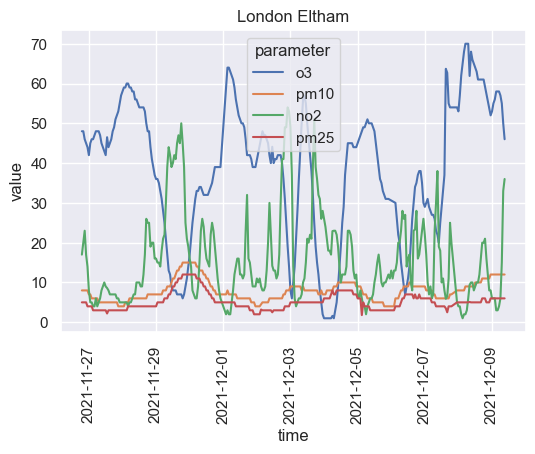

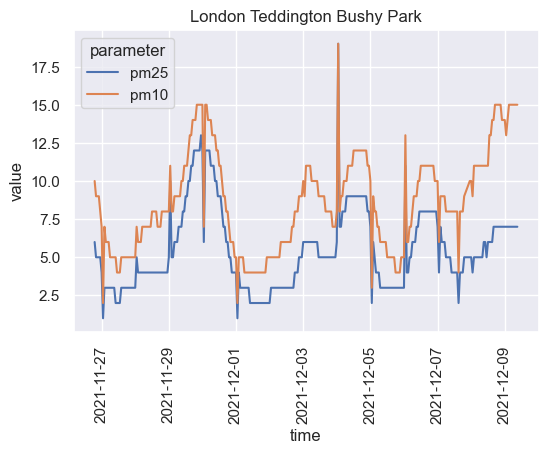

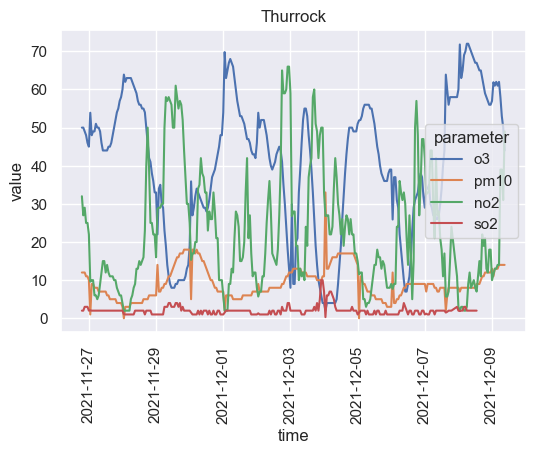

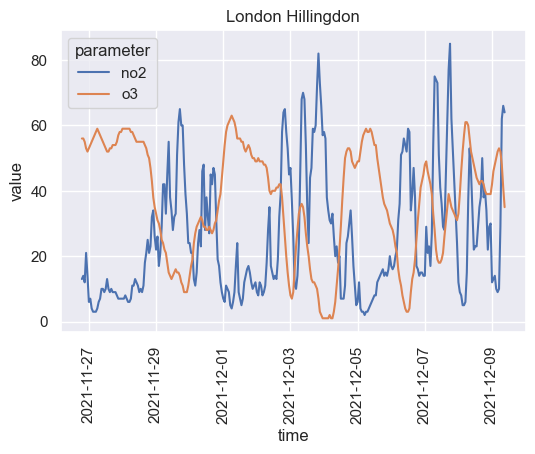

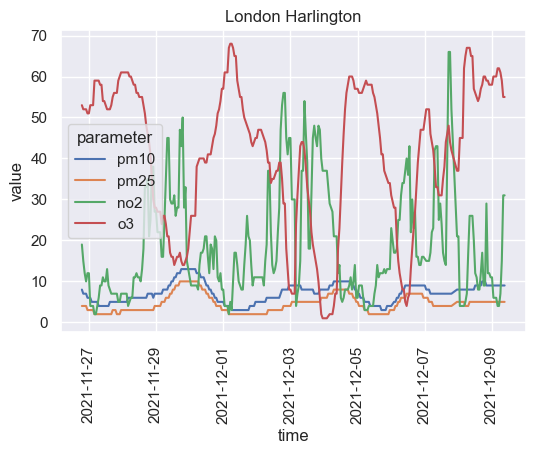

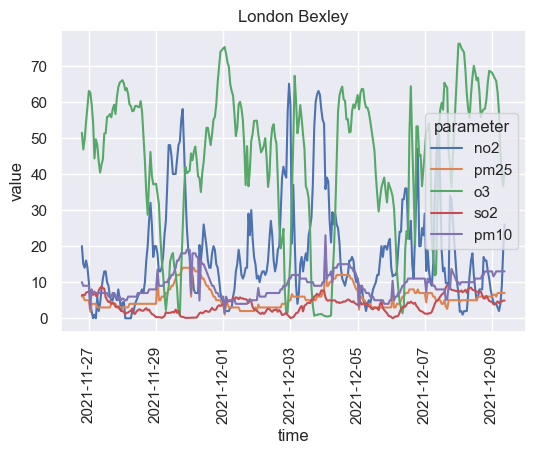

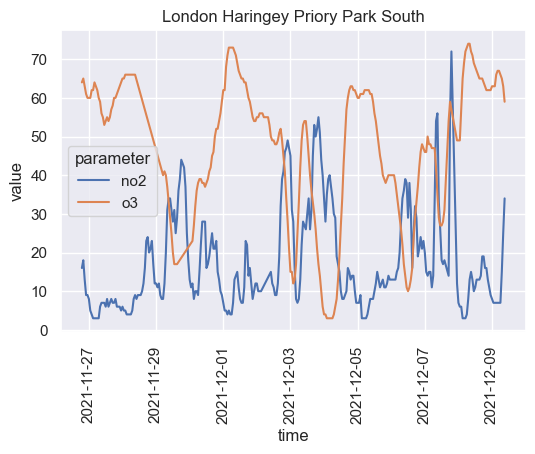

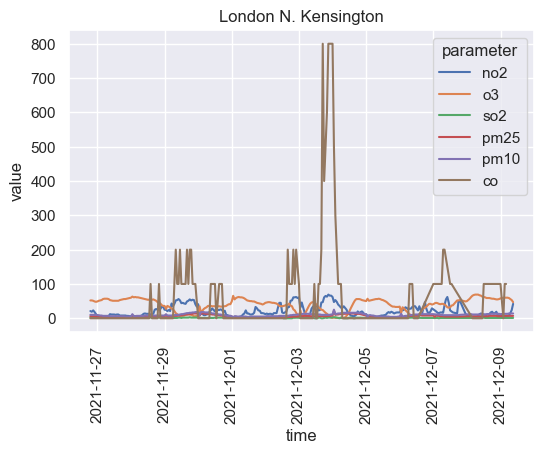

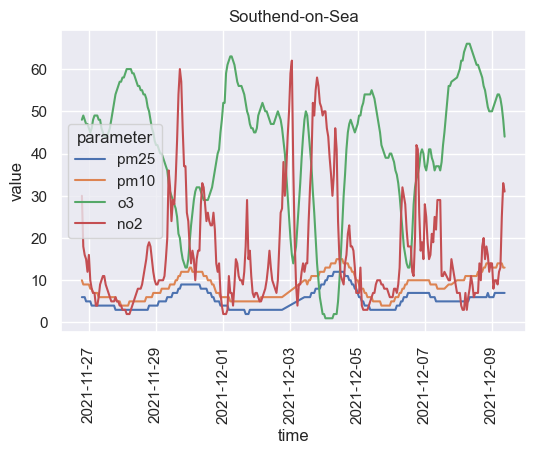

In [8]:

## (1) format the diagrams
plt.rcParams['figure.dpi'] = 100  
sns.set_theme(style='darkgrid') 

## (2) plot pollutant dynamic diagrams all over London
# create a loop to read the data in different locations and present them in the diagrams
for i in locations:
    sns.lineplot(data=london[london["location"] == i],
                 x='date.local', y='value', hue='parameter')
    plt.xlabel("time")
    plt.title(i)
    plt.xticks(rotation=90)
    plt.show()

In [9]:
# output all time and remove duplicate elements
parameter = london['parameter'].unique()
time=london.index.unique()
time=time[::-1]
time

DatetimeIndex(['2021-11-26 19:00:00', '2021-11-26 20:00:00',
               '2021-11-26 21:00:00', '2021-11-26 22:00:00',
               '2021-11-26 23:00:00', '2021-11-27 00:00:00',
               '2021-11-27 01:00:00', '2021-11-27 02:00:00',
               '2021-11-27 03:00:00', '2021-11-27 04:00:00',
               ...
               '2021-12-09 00:00:00', '2021-12-09 01:00:00',
               '2021-12-09 02:00:00', '2021-12-09 03:00:00',
               '2021-12-09 04:00:00', '2021-12-09 05:00:00',
               '2021-12-09 06:00:00', '2021-12-09 07:00:00',
               '2021-12-09 08:00:00', '2021-12-09 09:00:00'],
              dtype='datetime64[ns]', name='date.local', length=300, freq=None)

## 3.3 Draw diagrams based on monthly data

* Scale our data time span from several days to several months.
* Rather than daily changes before, we investigate monthly changes

In [10]:
## (1) define pollutant_change_month function to draw a picture about monthly changes
def pollutant_change_month(location, title):
    '''
    Return an image with the month as the abscissa and the monthly pollutant change as the ordinate
    Input:
        location: data about specific pollutant in London Bexley from 2021-01-01 to 2021-10-31
        title: the title of diagram
    Output:
        plot: the output is an image with the changes of different pollutants in the past ten months
    ''' 
    
    # add a column of the month in which the data is recorded
    location['month'] = location['date.utc'].dt.month
    # obtain the mean of pollutant of each month
    mean = location.groupby(['month','parameter'])['value'].mean()
    # put the data into dataframe
    df = pd.DataFrame(mean)
    # draw a data trend chart of the changes of different pollutants in the past ten months
    s = sns.lineplot(data=df,    
             x='month',
             y='value', 
             hue='parameter')
    # Set up the x axis
    s.set_xticks(range(11))
    # add title
    plt.title(title)
    return plt.show()



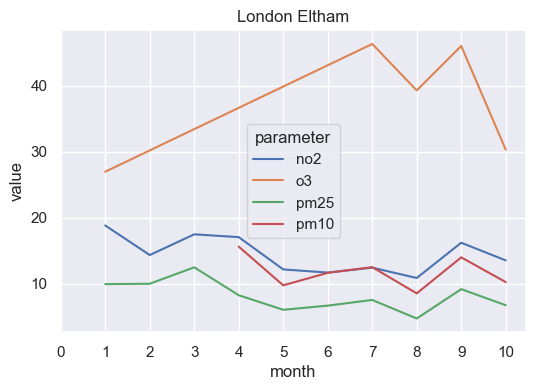

None


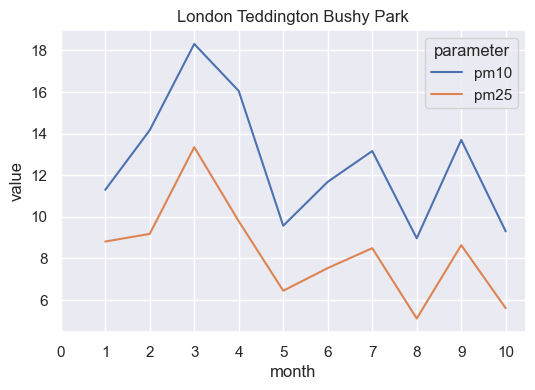

None


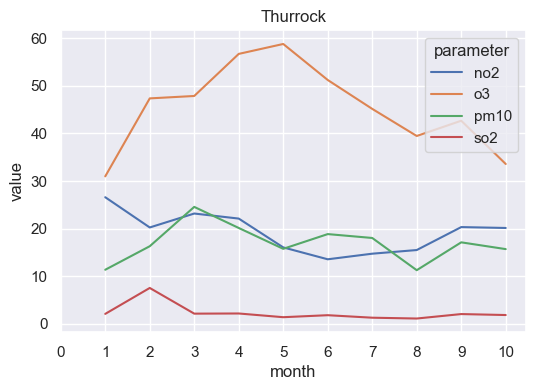

None


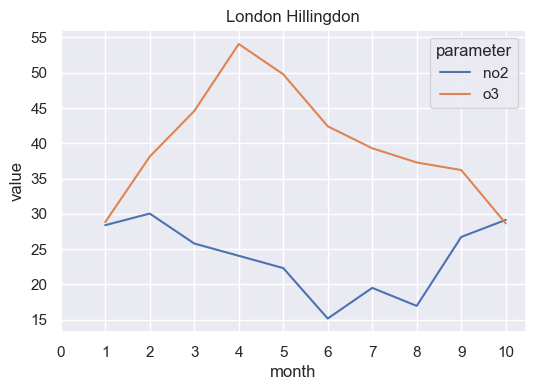

None


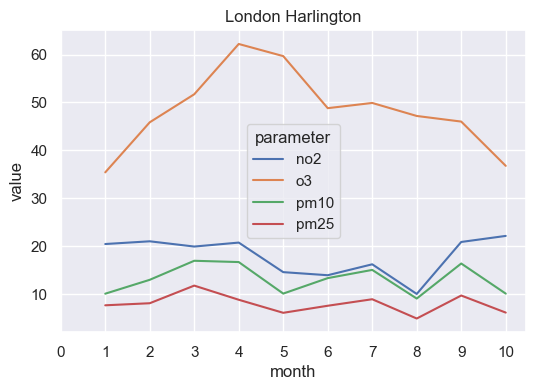

None


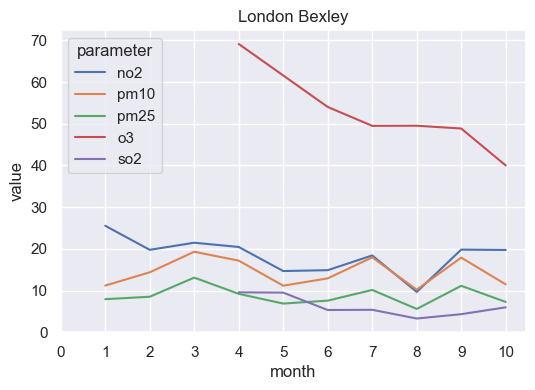

None


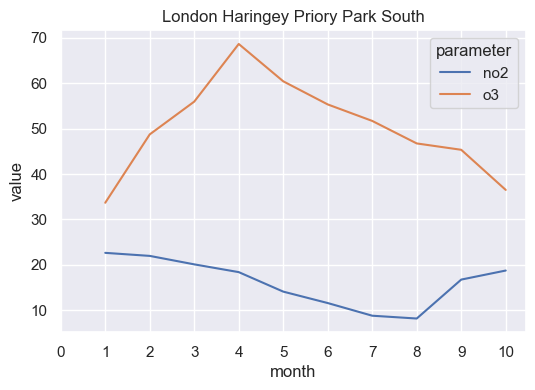

None


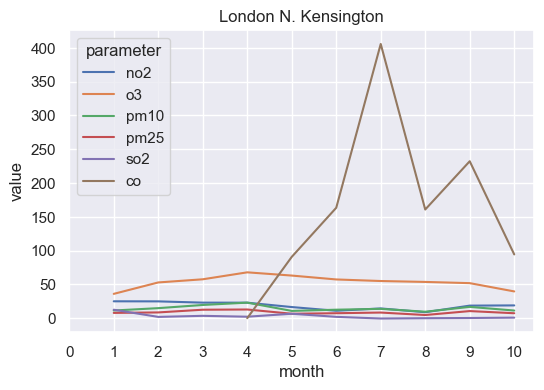

None


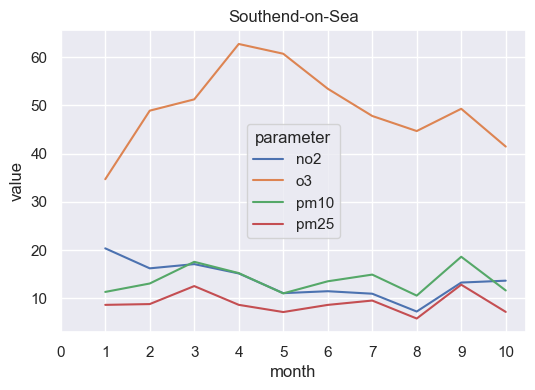

None


In [11]:
## (2) For loop to display pictures with monthly changes among locations in London
for i in locations:
    #collect the data from London Bexley from 2021-07-24 to 2021-12-31
    location1 = api.measurements(city='London', location=i,parameter=[
        'pm25', 'pm10', 'so2', ' co', ' no2', 'o3', ' bc'],date_from='2021-07-24',date_to='2021-10-31',has_geo=True,limit=10000,df=True)
    #collect the data from London Bexley from 2021-04-01 to 2021-07-23
    location2 = api.measurements(city='London', location=i,parameter=[
    'pm25', 'pm10', 'so2', ' co', ' no2', 'o3', ' bc'],date_from='2021-04-01',date_to='2021-7-23',has_geo=True,limit=10000,df=True)
    #collect the data from London Bexley from 2021-01-01 to 2021-03-31
    location3 = api.measurements(city='London', location=i,parameter=[
        'pm25', 'pm10', 'so2', ' co', ' no2', 'o3', ' bc'],date_from='2021-01-01',date_to='2021-3-31',has_geo=True,limit=10000,df=True)

    #put all the data in the last ten months in a dataframe
    location = location1.append(location2)
    location = location.append(location3)
    # display picture
    print(pollutant_change_month(location, i))

Take Bexley as an example to analyze:

* From that chart, it is obvious that o3 has considerable changes in the past ten months.The data has been on a downward trend since April.

* From that chart, it is obvious that no2, pm10, pm2.5, so2 have slight fluctuations. 

* In addition, the data value of these pollutants in August is relatively small, and the data value in March is relatively large.

## 4. Weather conditions & air pollution

In this part, we take pm2.5 as an example to analyze the relationship between weather condition and air condition

In [13]:
## (1) read the data in pollutant stations
geo_data = pd.DataFrame([])
geo_data = london[['location',
                   'coordinates.latitude', 'coordinates.longitude']]
geo_data = geo_data.drop_duplicates(subset='location')
geo_data = geo_data.reset_index(drop=True)
geo_data

,location,coordinates.latitude,coordinates.longitude
0,London Eltham,51.452580,0.070766
1,London Teddington Bushy Park,51.425286,-0.345606
2,Thurrock,51.477070,0.317969
3,London Hillingdon,51.496330,-0.460861
4,London Harlington,51.488790,-0.441614
5,London Bexley,51.466030,0.184806
6,London Haringey Priory Park South,51.584128,-0.125254
7,London N. Kensington,51.521050,-0.213492
8,Southend-on-Sea,51.544206,0.678408


In [14]:
## (2) create a loop to read data about weather
wea_data=[]
for i in geo_data.index:
    stations = meteostat.Stations()
    # obtain the latitude and longitude of locations
    stations = stations.nearby(geo_data.loc[i]['coordinates.latitude'], geo_data.loc[i]['coordinates.longitude'])
    # obtain the time
    stations = stations.inventory('daily', datetime(2020, 1, 1))
    # obtain the updated element's data
    station = stations.fetch(1)
    # add the data into the dataset
    wea_data.append(station)
    print(station)


                      name country region   wmo  icao  latitude  longitude  \
id                                                                           
EGLC0  London / Abbey Wood      GB    ENG  <NA>  EGLC      51.5     0.1167   

       elevation       timezone hourly_start hourly_end daily_start  \
id                                                                    
EGLC0        5.0  Europe/London   1988-01-29 2021-12-07  2007-09-26   

       daily_end monthly_start monthly_end     distance  
id                                                       
EGLC0 2021-12-05    2016-01-01  2021-01-01  6158.188829  
                          name country region    wmo  icao  latitude  \
id                                                                     
03772  London Heathrow Airport      GB    ENG  03772  EGLL   51.4833   

       longitude  elevation       timezone hourly_start hourly_end  \
id                                                                   
03772      -0.45    

The number of weather observation stations does not match the number of pollutant observation stations before, so take the average for analysis

In [24]:
## (3) add weather data to the dataset
# create time period
start=datetime.strptime(str(time[0]), '%Y-%m-%d %H:%M:%S')
end=datetime.strptime(str(time[-1]), '%Y-%m-%d %H:%M:%S')
ana_datas=pd.DataFrame([])

# create a loop to read the weather data and add them to the dataset according to the time sequence
for i in range(len(wea_data))[:1]:
    stations = meteostat.Stations()
    stations = stations.nearby(geo_data.loc[i]['coordinates.latitude'], geo_data.loc[i]['coordinates.longitude'])
    stations = stations.inventory('daily', datetime(2020, 1, 1))
    station = stations.fetch(1)
    ana_data = meteostat.Hourly(station, start=start, end=end)
    ana_data = ana_data.normalize()
    ana_data = ana_data.fetch()
    ana_datas=pd.concat([ana_datas,ana_data],axis=0)
ana_datas

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco
time,,,,,,,,,,,
2021-11-26 19:00:00,6.0,-1.0,61.0,0.0,NaN,280.0,26.0,NaN,989.0,NaN,NaN
2021-11-26 20:00:00,5.0,-1.0,65.0,0.0,NaN,270.0,30.0,NaN,988.0,NaN,NaN
2021-11-26 21:00:00,5.0,0.0,70.0,0.0,NaN,270.0,26.0,NaN,987.0,NaN,NaN
2021-11-26 22:00:00,4.0,-1.0,70.0,0.0,NaN,250.0,28.0,NaN,986.0,NaN,NaN
2021-11-26 23:00:00,4.0,0.0,75.0,0.1,NaN,250.0,30.0,NaN,985.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09 05:00:00,6.0,0.7,69.0,0.0,NaN,267.0,20.2,NaN,1000.7,NaN,NaN
2021-12-09 06:00:00,5.6,0.4,69.0,0.0,NaN,268.0,18.7,NaN,1001.1,NaN,NaN
2021-12-09 07:00:00,4.1,0.2,76.0,0.0,NaN,262.0,15.1,NaN,1001.5,NaN,NaN


|Code|  Meaning|
|---|---|
|temp|	Air Temperature|
|dwpt|	Dew Point|
|rhum|	Relative Humidity|
|prcp|	Total Precipitation|
|snow|	Snow Depth|
|wdir|	Wind (From) Direction|
|wspd|	Average Wind Speed|
|wgpt|	Wind Peak Gust|
|pres|	Sea-Level Air Pressure|
|tsun|	Total Sunshine Duration|
|coco|	Weather Condition Code|

In [16]:
# remove nulls
ana_datas = ana_datas.dropna(axis=1,how='all')
# count the number of null values for each column varible
col_null = ana_datas.isnull().sum(axis=0)
col_null

temp      0
dwpt      0
rhum      0
prcp      0
wdir      0
wspd      0
pres      0
coco    292
dtype: int64

Because coco has more null values, it is discarded

In [17]:
# drop coco
ana_datas=ana_datas.drop(columns='coco')
ana_datas

,temp,dwpt,rhum,prcp,wdir,wspd,pres
time,,,,,,,
2021-11-26 19:00:00,6.0,-1.0,61.0,0.0,280.0,26.0,989.0
2021-11-26 20:00:00,5.0,-1.0,65.0,0.0,270.0,30.0,988.0
2021-11-26 21:00:00,5.0,0.0,70.0,0.0,270.0,26.0,987.0
2021-11-26 22:00:00,4.0,-1.0,70.0,0.0,250.0,28.0,986.0
2021-11-26 23:00:00,4.0,0.0,75.0,0.1,250.0,30.0,985.0
...,...,...,...,...,...,...,...
2021-12-09 05:00:00,6.0,0.7,69.0,0.0,267.0,20.2,1000.7
2021-12-09 06:00:00,5.6,0.4,69.0,0.0,268.0,18.7,1001.1
2021-12-09 07:00:00,4.1,0.2,76.0,0.0,262.0,15.1,1001.5


In [48]:
## (4) combine the data and take the average of the pollutant 

great_londons = []
for i in ana_datas.index:
    try:
        great_london = london[london['parameter'] ==
                              'pm25'].loc[i][['parameter', 'value']]
        lang = great_london.shape[0]
        great_london.loc['sum'] = great_london.apply(lambda x: x.sum())
        great_london = great_london.loc['sum']['value']/lang
        great_londons.append(great_london)
    except:
        great_londons.append(great_londons[-1])

# add great_londons into ana_datas
ana_datas['value']=great_londons
ana_datas    

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,tsun,coco,value
time,,,,,,,,,,,,
2021-11-26 19:00:00,6.0,-1.0,61.0,0.0,NaN,280.0,26.0,NaN,989.0,NaN,NaN,5.500000
2021-11-26 20:00:00,5.0,-1.0,65.0,0.0,NaN,270.0,30.0,NaN,988.0,NaN,NaN,5.333333
2021-11-26 21:00:00,5.0,0.0,70.0,0.0,NaN,270.0,26.0,NaN,987.0,NaN,NaN,5.166667
2021-11-26 22:00:00,4.0,-1.0,70.0,0.0,NaN,250.0,28.0,NaN,986.0,NaN,NaN,5.000000
2021-11-26 23:00:00,4.0,0.0,75.0,0.1,NaN,250.0,30.0,NaN,985.0,NaN,NaN,4.500000
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-09 05:00:00,6.0,0.7,69.0,0.0,NaN,267.0,20.2,NaN,1000.7,NaN,NaN,6.500000
2021-12-09 06:00:00,5.6,0.4,69.0,0.0,NaN,268.0,18.7,NaN,1001.1,NaN,NaN,6.500000
2021-12-09 07:00:00,4.1,0.2,76.0,0.0,NaN,262.0,15.1,NaN,1001.5,NaN,NaN,6.500000


In [55]:
# find the pearsonr correlation coefficient between weather condition and Pm2.5
r=[0 for i in range(6)]
p=[0 for i in range(6)]
r[0],p[0] = stats.pearsonr(ana_datas.temp,ana_datas.value)
r[1],p[1] = stats.pearsonr(ana_datas.dwpt,ana_datas.value)
r[2],p[2] = stats.pearsonr(ana_datas.rhum,ana_datas.value)
r[3],p[3] = stats.pearsonr(ana_datas.prcp,ana_datas.value)
r[4],p[4] = stats.pearsonr(ana_datas.wdir,ana_datas.value)
r[5],p[5] = stats.pearsonr(ana_datas.wspd,ana_datas.value)

# display the results
pearsonr = {"pearsonr coefficient": r, "significance": p}
pearson = pd.DataFrame(pearsonr, index=["temp", "dwpt", "rhum", "prcp", "wdir", "wspd"])
display(pearson)

,pearsonr coefficient,significance
temp,0.141844,1.345970e-02
dwpt,0.181091,1.548655e-03
rhum,0.108146,6.007756e-02
prcp,-0.062392,2.789783e-01
wdir,-0.354025,2.244274e-10
wspd,-0.059701,3.002744e-01


# 4. Extension

* Moreover, we draw a heatmap to supplement our richness of map.
* The heatmap is automatically open on internet web.

In [60]:
# plot the dynamic heat map
for i in parameter:
    data_move = []
# create a loop to read the data  
    for j in time:
        try:
            # obtain the latitude and longitude of the parameter and add them to the dataset
            data = london[london['parameter'] == i][[
                'coordinates.latitude', 'coordinates.longitude', 'value']]
            data_move.append(data.loc[j].values.tolist())
        except:
            continue
    # input the data into the map
    heatmap = folium.Map(location = [london['coordinates.latitude'].mean(
    ), london['coordinates.longitude'].mean()], zoom_start = 9.5, control_scale = True)
    # format the map and save it, which can be shown on web (seeing it based on the last line)
    hm=folium.plugins.HeatMapWithTime(data_move, radius=100, gradient={.1: 'blue', .5: 'lime', 1: 'yellow'})
    hm.add_to(heatmap)
    file_path=r"{0}.html".format(i)
    hm.add_to
    heatmap.save(file_path)
    webbrowser.open(file_path)
